In [1]:
%matplotlib inline

# Tutorial for Kinetics Toolkit's anthropometrics extension

The `anthropometrics` extension aims to assist the reconstruction of human-specific points of anatomy, to establish trajectories of segment orientations via standardised local coordinate systems, and to estimate the segment's centers of mass and inertial properties.

In this tutorial, we will work on a static acquisition where we probed and followed a set of bony landmarks. We will infer joint centers based on these landmarks, then we will estimate the segments' centers of mass, and finally we will track local coordinate systems for every segment.

In [2]:
import kineticstoolkit.lab as ktk
import numpy as np

We will start by loading a sample dataset, inspect its contents and show it in a player.

In [3]:
markers = ktk.load(
    ktk.doc.download('anthropometrics_static.ktk.zip')
)

# Print the available markers
markers.data

{
                    'LegR_Marker1': <array of shape (614, 4)>
                    'LegR_Marker3': <array of shape (614, 4)>
                    'LegR_Marker4': <array of shape (614, 4)>
                    'LegL_Marker1': <array of shape (614, 4)>
                    'LegL_Marker2': <array of shape (614, 4)>
                    'LegL_Marker3': <array of shape (614, 4)>
                    'LegL_Marker4': <array of shape (614, 4)>
                    'ArmR_Marker1': <array of shape (614, 4)>
                    'ArmR_Marker2': <array of shape (614, 4)>
                    'ArmR_Marker3': <array of shape (614, 4)>
                    'ArmR_Marker4': <array of shape (614, 4)>
                    'ArmL_Marker1': <array of shape (614, 4)>
                    'ArmL_Marker2': <array of shape (614, 4)>
                    'ArmL_Marker3': <array of shape (614, 4)>
                    'ArmL_Marker4': <array of shape (614, 4)>
                    'LegR_Marker2': <array of shape (614, 4)>
      

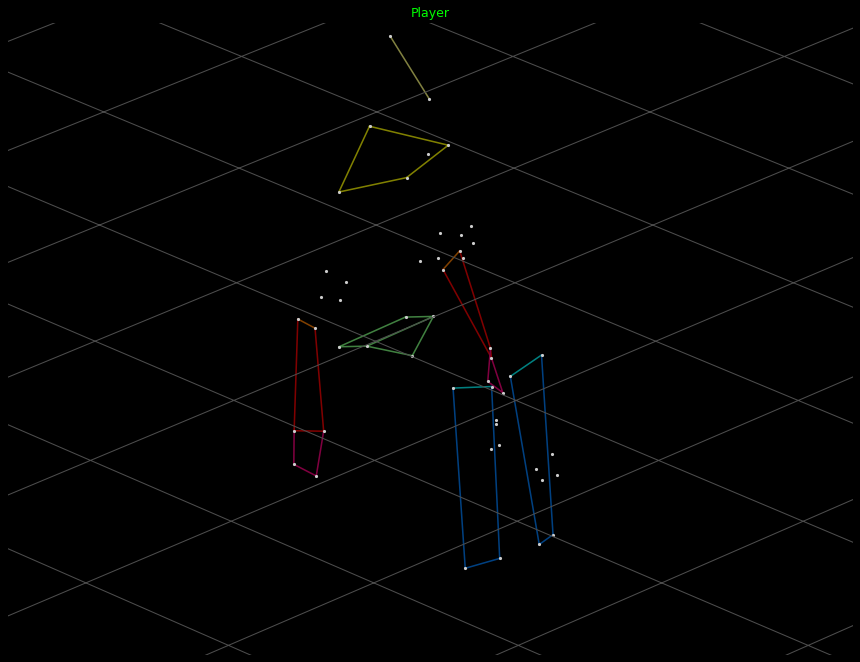

In [4]:
# Show in a Player
viewpoint = {
    'zoom': 3.5,
    'azimuth': -2.356,
    'elevation': 0.384,
    'translation': (0.083, 0.184),
    'target': (-4.435, 0.726, 0.540,  1.),
}

player = ktk.Player(
    markers,
    segments=ktk.ext.anthropometrics.LINKS,  # Lines to better see the human shape
    **viewpoint
)

## Infer joint centers

Although a lot of markers are already available in this acquisition, the joint centers are undefined. We will first add the hips and L5S1, which are defined by the pelvis segment.

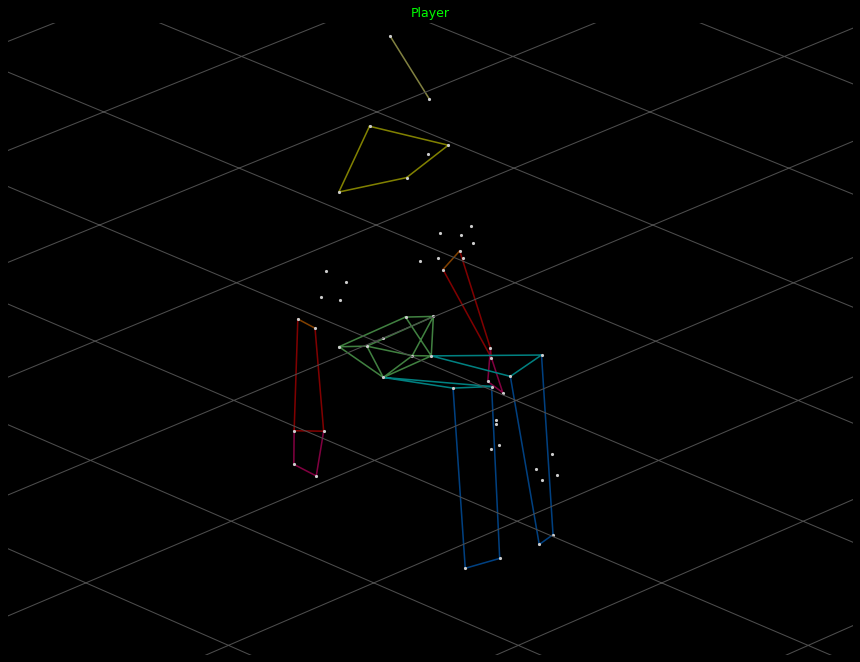

In [5]:
markers = markers.merge(
    ktk.ext.anthropometrics.infer_joint_centers(
        markers, segment='Pelvis', sex='M'
    )
)

player = ktk.Player(
    markers,
    segments=ktk.ext.anthropometrics.LINKS,  # Lines to better see the human shape
    **viewpoint
)

Then, we can add the glenohumeral joints and C7T1, which are defined by the thorax segment.

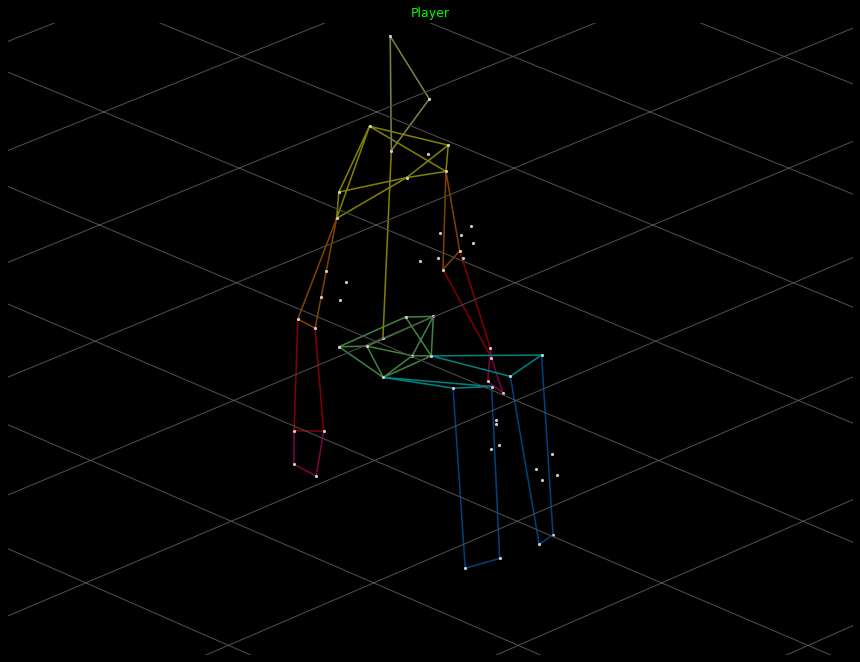

In [6]:
markers = markers.merge(
    ktk.ext.anthropometrics.infer_joint_centers(
        markers, segment='Thorax', sex='M'
    )
)

player = ktk.Player(
    markers,
    segments=ktk.ext.anthropometrics.LINKS,  # Lines to better see the human shape
    **viewpoint
)

Finally, we add the joint centers for the extremities, which are calculated as the midpoint between their respective lateral and medial bony landmarks.

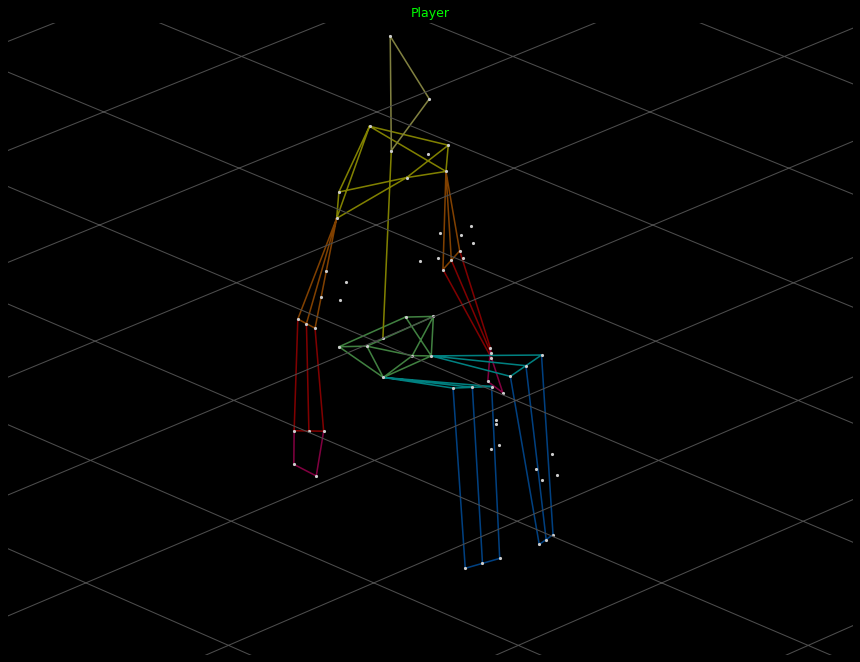

In [7]:
markers = markers.merge(
    ktk.ext.anthropometrics.infer_joint_centers(
        markers, segment='Extremities'
    )
)

player = ktk.Player(
    markers,
    segments=ktk.ext.anthropometrics.LINKS,  # Lines to better see the human shape
    **viewpoint
)

Now that every joint center is reconstructed based on this static acquisition, we may to include these joint centers into marker clusters so that they can be reconstructed later in an analyzed action.

In [8]:
clusters = {}
clusters['Pelvis'] = ktk.kinematics.create_cluster(
    markers, [
        'AnteriorSuperiorIliacSpineR',
        'AnteriorSuperiorIliacSpineL',
        'PosteriorSuperiorIliacSpineR',
        'PosteriorSuperiorIliacSpineL',
        'PubicSymphysis',
        'L5S1JointCenter',
        'HipJointCenterR',
        'HipJointCenterL',
    ]
)

clusters['Thorax'] = ktk.kinematics.create_cluster(
    markers, [
        'C7',
        'Xiphoid',
        'Suprasternale',
        'C7T1JointCenter',
    ]
)

clusters['HeadNeck'] = ktk.kinematics.create_cluster(
    markers, [
        'Sellion',
        'HeadVertex',
        'Chin',
    ]
)

for side in ['R', 'L']:

    clusters[f'Arm{side}'] = ktk.kinematics.create_cluster(
        markers, [
            f'Arm{side}_Marker1',
            f'Arm{side}_Marker2',
            f'Arm{side}_Marker3',
            f'Arm{side}_Marker4',
            f'GlenohumeralJointCenter{side}',
            f'LateralHumeralEpicondyle{side}',
            f'MedialHumeralEpicondyle{side}',
            f'ElbowJointCenter{side}',
        ]
    )

    clusters[f'Forearm{side}'] = ktk.kinematics.create_cluster(
        markers, [
            f'ElbowJointCenter{side}',
            f'UlnarStyloid{side}',
            f'RadialStyloid{side}',
            f'WristJointCenter{side}',
        ]
    )

    clusters[f'Hand{side}'] = ktk.kinematics.create_cluster(
        markers, [
            f'WristJointCenter{side}',
            f'CarpalMetaHead2{side}',
            f'CarpalMetaHead5{side}',
        ]
    )

    clusters[f'Thigh{side}'] = ktk.kinematics.create_cluster(
        markers, [
            f'HipJointCenter{side}',  # Normally I would remove this one.
            f'LateralFemoralEpicondyle{side}',
            f'MedialFemoralEpicondyle{side}',
            f'KneeJointCenter{side}',
        ]
    )

    clusters[f'Leg{side}'] = ktk.kinematics.create_cluster(
        markers, [
            f'Leg{side}_Marker1',
            f'Leg{side}_Marker2',
            f'Leg{side}_Marker3',
            f'Leg{side}_Marker4',
            f'LateralMalleolus{side}',
            f'MedialMalleolus{side}',
            f'KneeJointCenter{side}',
            f'AnkleJointCenter{side}',
        ]
    )

## Estimate centers of mass

Now that the joint centers are defined, it is possible to estimate the center of mass for every segment.

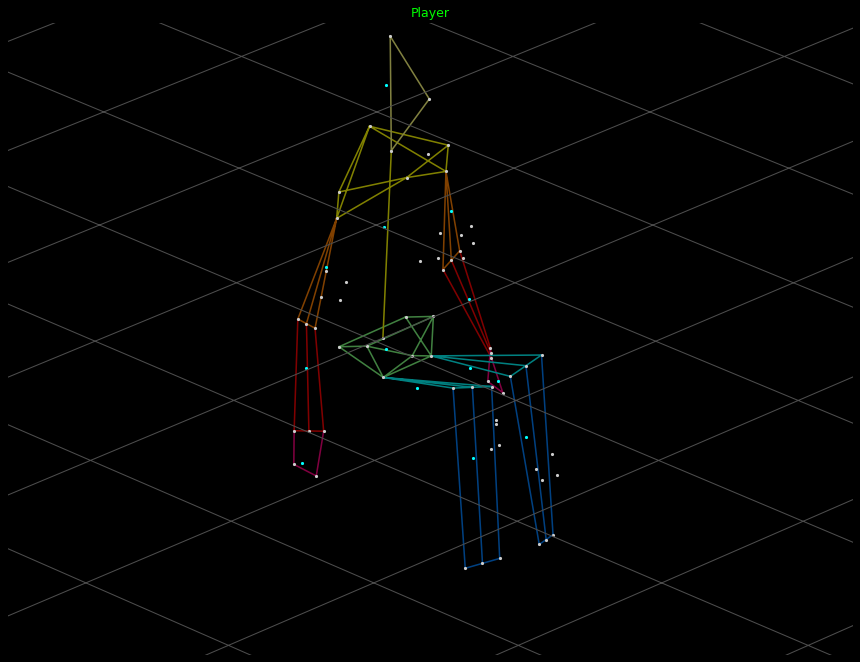

In [9]:
segments = [
    'Pelvis', 'Thorax', 'HeadNeck', 'ArmR', 'ArmL', 'ForearmR', 'ForearmL',
    'HandR', 'HandL', 'ThighR', 'ThighL', 'LegR', 'LegL'
]

com = ktk.ext.anthropometrics.estimate_center_of_mass(
    markers, segments)

# Paint the centers of mass in cyan for better visualization
for marker in com.data:
    com = com.add_data_info(marker, 'Color', 'c')
    
player = ktk.Player(
    markers,
    com,
    segments=ktk.ext.anthropometrics.LINKS,  # Lines to better see the human shape
    **viewpoint
)

### Track local coordinate systems

To perform a kinematic analysis of a given task, one could use the reconstructed markers to set standard segment's local coordinate system and track those segments.

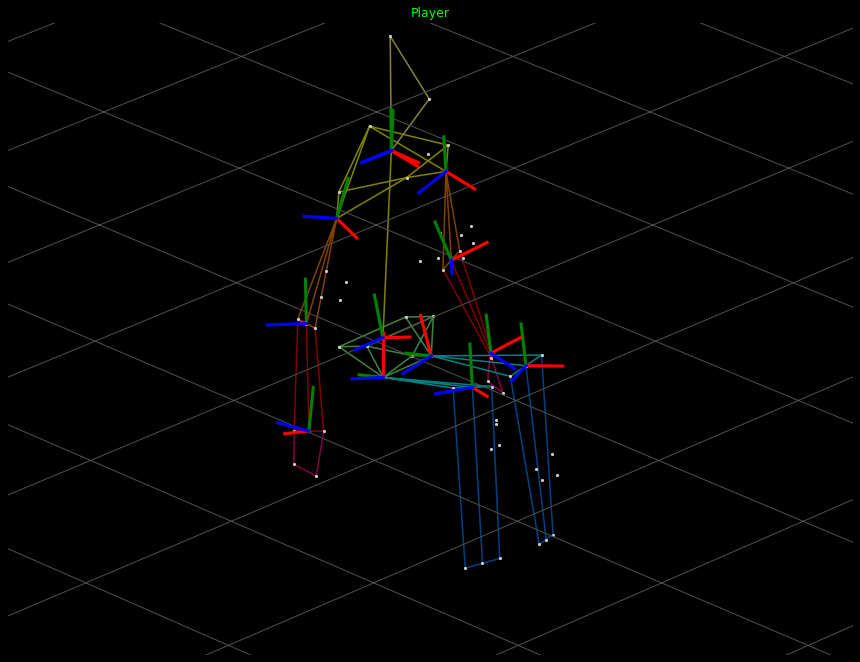

In [10]:
bodies = ktk.ext.anthropometrics.track_local_coordinate_systems(
        markers, segments)

player = ktk.Player(
    markers,
    bodies,
    segments=ktk.ext.anthropometrics.LINKS,  # Lines to better see the human shape
    **viewpoint
)